In [1]:
import time

import argparse
from bigmdp.data.env_gym import SimpleNormalizeEnv
from bigmdp.data.dataset import SimpleReplayBuffer
from bigmdp.utils.utils_log import *
from bigmdp.utils.utils_video import *
from bigmdp.utils.tmp_vi_helper import *
from bigmdp.utils.image_wrappers import *
from bigmdp.hyper_params import HYPERPARAMS
from bigmdp.utils.utils_directory import *
# from async_vi.MDP import *
import numpy as np

from bigmdp.mdp.MDP_GPU import FullMDP
import pycuda.autoinit

# Get all Arguments
parser = argparse.ArgumentParser()
parser.add_argument("--bottle_neck_size", help="size", type=int, default=32)
parser.add_argument("--discrete_bn", help="size", type=int, default=0)
parser.add_argument("--multiplyer", help="multiplyer of feature space", type=int, default=10)
parser.add_argument("--env", help="environment name", type=str, default="CartPole")
parser.add_argument("--name", help="Experiment name", type=str, default="CartPoleR1")
parser.add_argument("--load", help="Load the previous MDP ?", type=int, default=0)
parser.add_argument("--symbolic", help="Use Symbolic env if 1 else use image based env", type=int, default=1)
parser.add_argument("--steps_to_train", help="Number of steps to train the whole pipeline", type=int, default=0)
parser.add_argument("--rmax", help="Use rmax exploration?", type=int, default=0)
parser.add_argument("--video_every", help="get a rollout video every", type=int, default= 999999999)


# args = parser.parse_args()
args = parser.parse_args("--video_every 50 --env CartPole --rmax 0 --multiplyer 10".split(" "))
base_file_path = "./result_dump/{}/{}".format(args.env, args.name +
                                              "_bn-" + str(args.bottle_neck_size) +
                                              "_sym-" + str(args.symbolic))

create_hierarchy(base_file_path)

def latent_to_hs_disc_fxn(s):
    if len(s)==1:
        return hAsh(s[0] * args.multiplyer)
    else:
        assert False

log_dirs_dict, loggers_dict = get_advanced_log_dir_and_logger(ROOT_FOLDER = "Symbolic" if args.symbolic else "Image",
                                                             EXP_ID = args.env,
                                                             EXP_PARAMS="_bn-" + str(args.bottle_neck_size) +
                                                                        "_sym-" + str(args.symbolic) +
                                                                        "_rmax-" + str(bool(args.rmax)),
                                                             tb_log_keys=["tb_train_logger", "tb_vi_logger"])


if args.symbolic:
    params = HYPERPARAMS[args.env + "-sym"]
    env = SimpleNormalizeEnv(params["env_name"], max_episode_length=params["max_episode_length"])
#     env = torch.load("cartpole_env.pk")
else:
    print("Not Implemented Yet")  # Todo
    params = HYPERPARAMS[args.env + "-img"]
    assert False

if args.load:
    mdp = torch.load(base_file_path + "mdp_class.pth")
else:
    mdp = FullMDP(A=env.get_list_of_actions(),
                  ur=params["unknown_transition_reward"],
                  vi_params={"gamma": params["gamma"],
                             "slip_prob": params["slip_probability"],
                             "rmax_reward": params["rmax_reward"],
                             "rmax_thres": 2,
                             "balanced_explr": True,
                             "rmin": params["rmin"]},
                  policy_params={"unhash_array_len":env._env.observation_space.shape[0]},
                  MAX_S_COUNT=int(1e6))

all_rewards = []
eval_rewards, safe_eval_rewards = [], []
policy_fetch_time = []
bellman_backup_time = [9999]
tran_buffer = SimpleReplayBuffer(int(params["replay_size"]))
eps_tracker = EpsilonTracker(params)

frame_count = 0
warmup_eps = 10
eval_reward = 0

safe_policy = lambda s : mdp.get_safe_action(latent_to_hs_disc_fxn([s]))
opt_policy =  lambda s : mdp.get_opt_action(latent_to_hs_disc_fxn([s]))
explr_policy =  lambda s : mdp.get_explr_action(latent_to_hs_disc_fxn([s]))
random_policy = lambda s: env.sample_random_action()


-1.7679447436352036 0.5308953889702623
-1.7679447436352036 0.5308953889702623
-3.2492148187065912 2.2862694716084992
-3.2492148187065912 2.2862694716084992
-0.2599483290973885 0.25375994400057567
-0.2599483290973885 0.25375994400057567
-3.065888710568323 3.0479722475155824
-3.065888710568323 3.0479722475155824
[{'min': -1.7679447436352036, 'max': 0.5308953889702623}, {'min': -3.2492148187065912, 'max': 2.2862694716084992}, {'min': -0.2599483290973885, 'max': 0.25375994400057567}, {'min': -3.065888710568323, 'max': 3.0479722475155824}]
normalizing_params_set


In [ ]:

for eps in range(100000):
    s = env.reset()
    running_reward = 0

    while True:
        frame_count += 1

        if frame_count > params["replay_initial"] and frame_count %10 == 0:
            st = time.time()
            mdp.do_optimal_backup(mode="GPU", n_backups=5)
            mdp.do_explr_backup(mode="GPU", n_backups=5)
            mdp.do_safe_backup(mode="GPU", n_backups=5)
            bellman_backup_time.append(time.time() - st)

        st = time.time()
        if frame_count < (params["replay_initial"] + 100) or (np.random.random() < eps_tracker.get_eps(frame_count) and not args.rmax):
            a = random_policy(s)
        else:
            a = explr_policy(s) if (args.rmax and eps%2==0) else opt_policy(s)
        policy_fetch_time.append(time.time() - st)


        ns, r, d, i = env.step(a)
        _d = False if d and i["max_episode_length_exceeded"] == True else d

        hs_d, hns_d = latent_to_hs_disc_fxn([s]), latent_to_hs_disc_fxn([ns])
        #         shared_store_1.add_to_transition_queue.remote([hs_d, a, hns_d, r, _d])
        mdp.consume_transition([hs_d, a, hns_d, r, _d])
        tran_buffer.add([s, a, ns, r, _d])

        running_reward += r
        s = ns

        if frame_count > params["replay_initial"] and eps % 10 == 0:
            env.render()

        if frame_count % params['checkpoint_every'] == 0:
            cache_mdp = mdp
            torch.save(cache_mdp, base_file_path + "mdp_class.pth")

        if d:
            print("-====-")
            break
            
    all_rewards.append(running_reward)


    #### Evaluation Code
    if frame_count > params["replay_initial"] and frame_count > params['checkpoint_every']:
        cache_mdp = mdp
        rmax_count = sum([1 for s in cache_mdp.tC for a in cache_mdp.tC[s] if sum(cache_mdp.tC[s][a].values()) < 10])
        #         vi_error, e_vi_error, s_vi_error = ray.get(shared_store_1.get_curr_vi_errors.remote())
        vi_error, e_vi_error, s_vi_error = [mdp.curr_vi_error, mdp.e_curr_vi_error, mdp.s_curr_vi_error]

        eval_reward = evaluate_on_env(env, opt_policy, eps_count=2, render=False)[0]
        eval_rewards.append(eval_reward)

        safe_eval_reward = evaluate_on_env(env, safe_policy, eps_count=2, render=False)[0]
        safe_eval_rewards.append(safe_eval_reward)

        loggers_dict["tb_train_logger"].add_scalar('Safe policy performance', float(safe_eval_reward), eps)
        loggers_dict["tb_train_logger"].add_scalar('Optimal policy performance', float(eval_reward), eps)
        loggers_dict["tb_train_logger"].add_scalar('Expl/Expt policy performance', float(running_reward), eps)

        loggers_dict["tb_train_logger"].add_scalar('MDP State Count', float(len(cache_mdp.vD)), eps)
        loggers_dict["tb_train_logger"].add_scalar('Rmax Count', float(rmax_count), eps)
        loggers_dict["tb_train_logger"].add_histogram('Optimal Value Distr', torch.tensor(list(cache_mdp.vD.values())), eps)
        loggers_dict["tb_train_logger"].add_histogram('Optimal Policy Distr', torch.tensor(list(cache_mdp.pD.values())), eps)

        loggers_dict["tb_train_logger"].add_scalar('Expl VI_error', float(e_vi_error), eps)
        loggers_dict["tb_train_logger"].add_scalar('Opt VI_error', float(vi_error), eps)
        loggers_dict["tb_train_logger"].add_scalar('Safe VI_error', float(s_vi_error), eps)

        loggers_dict["tb_train_logger"].add_scalar('Explr Epsilon', float(eps_tracker.get_eps(frame_count)), eps)
        loggers_dict["tb_train_logger"].add_scalar('Policy Fetch rate', float(mean(policy_fetch_time)), eps)

        print("episode:", eps,
              "reward:", running_reward,
              #               "Bkp error:", [round(d,6) for d in ray.get(shared_store_1.get_curr_vi_errors.remote())],
              "Bkp error:", [round(d, 6) for d in [mdp.curr_vi_error, mdp.e_curr_vi_error, mdp.s_curr_vi_error]],
              "s8 visited:", len(mdp.tC),
              "Rmax S8 Count", rmax_count,safe_eval_reward,
              "epsilon", round(eps_tracker.get_eps(frame_count), 2),
              "Eval Reward", eval_reward,safe_eval_reward,
              "policy_fetch_rate", round(mean(policy_fetch_time), 6),
              "bellman_backup_time", round(mean(bellman_backup_time), 6) if bellman_backup_time else 0
              )

        policy_fetch_time = []
        bellman_backup_time = []

    if eps%args.video_every == 0 and eps != 0 and frame_count>params['checkpoint_every']:
        nn_performance, info_ , video = rollout_with_nn_behavior(env = env,
                                                                 policy = explr_policy if args.rmax else opt_policy,
                                                                 hs_nn_fxn = lambda hs: mdp._get_nn_hs(hs),
                                                                 pi_dict = cache_mdp.pD,
                                                                 v_dict = cache_mdp.e_vD if args.rmax else cache_mdp.vD ,
                                                                 hs_st_disc_fxn = latent_to_hs_disc_fxn,
                                                                 A = env.get_list_of_actions(),
                                                                 tranDict = cache_mdp.tD,
                                                                 rewardDict = cache_mdp.e_rD,
                                                                 eps=2, render=False)
        save_video(video, title = "rollout_t_DECODE_NN_" + str(eps), base_path=log_dirs_dict["py_log_dir"])

-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
-====-
episode: 32 reward: 33.0 Bkp error: [307.88916, 11210.625, 194.046967] s8 visited: 440 Rmax S8 Count 870 53.0 epsilon 0.1 Eval Reward 46.5 53.0 policy_fetch_rate 0.001004 bellman_backup_time 109.086123
-====-
episode: 33 reward: 84.0 Bkp error: [1.604557, 961.625, 2.619591] s8 visited: 448 Rmax S8 Count 880 29.0 epsilon 0.1 Eval Reward 53.5 29.0 policy_fetch_rate 0.000559 bellman_backup_time 0.477795
-====-
episode: 34 reward: 61.0 Bkp error: [4.709023, 20441.046875, 581.354431] s8 visited: 460 Rmax S8 Count 902 28.0 epsilon 0.1 Eval Reward 34.0 28.0 policy_fetch_rate 0.001015 bellman_backup_time 0.48362
-====-
episode: 35 reward: 45.0 Bkp error: [5.690104, 42790.8125, 131.283203] s8 visited: 474 Rmax S8 Count 930 21.5 epsilon 0.1 Eval Reward 47.5 21.5 policy

In [3]:
mdp.vi_params

{'gamma': 0.99,
 'slip_prob': 0.1,
 'rmax_reward': 10000,
 'rmax_thres': 2,
 'balanced_explr': True,
 'rmin': -10}

In [4]:
eval_reward = evaluate_on_env(env, opt_policy, eps_count=100, render=False)[0]
eval_rewards.append(eval_reward)
print(eval_reward)

47.53


In [5]:
# # opt_policy_new = lambda s :mdp._get_nn_hs(s)
# def opt_policy_new(s):
#     s1 = mdp._get_nn_hs_gpu(latent_to_hs_disc_fxn([s]))
#     s2 = mdp._get_nn_hs(latent_to_hs_disc_fxn([s]))
#     print(s,s1,s2)
#     assert s1 ==s2
#     return mdp.pD[s1]
    
    
# # opt_policy_new =  lambda s : mdp.pD[mdp._get_nn_hs_gpu(latent_to_hs_disc_fxn([s]))]
# eval_reward = evaluate_on_env(env, opt_policy_new, eps_count=100, render=False)[0]
# eval_rewards.append(eval_reward)
# print(eval_reward)




mdp.s_vDg

In [6]:
mdp.s_vD_gpu.get()

array([[   0.     ],
       [   0.     ],
       [-284.46304],
       ...,
       [   0.     ],
       [   0.     ],
       [   0.     ]], dtype=float32)

In [7]:
mdp.vD

defaultdict(<function bigmdp.mdp.MDP_GPU.init2zero()>,
            {'unknown_state': 0.0,
             'end_state': 0.0,
             '[2, 0, -1, 0]': 34.9420051574707,
             '[0, 0, 0, 0]': 32.468177795410156,
             '[2, -1, -1, 1]': 31.706472396850586,
             '[2, -1, 0, 1]': 32.37601089477539,
             '[2, 0, 0, 0]': 35.289188385009766,
             '[2, 1, 0, -1]': 34.673702239990234,
             '[2, 2, 0, -2]': 35.59607696533203,
             '[2, 2, -1, -3]': 23.139122009277344,
             '[2, 3, -1, -4]': 8.49087142944336,
             '[2, 4, -2, -5]': 7.5665364265441895,
             '[3, 4, -3, -5]': 6.632864952087402,
             '[3, 4, -4, -5]': 5.290563106536865,
             '[3, 3, -5, -4]': 4.333902359008789,
             '[3, 4, -6, -5]': 3.152031183242798,
             '[3, 3, -7, -4]': 2.235024929046631,
             '[4, 2, -8, -3]': 1.0,
             '[3, 1, 0, -1]': 29.510242462158203,
             '[3, 2, 0, -2]': 28.11123085021972

In [19]:
0.1 * 79.97235  

7.997235000000001

In [17]:
mdp.

In [10]:
mdp.rewardMatrix_gpu

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

(array([639., 291., 307., 206.,  78.,  57.,  28.,  25.,  23.,  23.]),
 array([ 0.        ,  4.91673241,  9.83346481, 14.75019722, 19.66692963,
        24.58366203, 29.50039444, 34.41712685, 39.33385925, 44.25059166,
        49.16732407]),
 <a list of 10 Patch objects>)

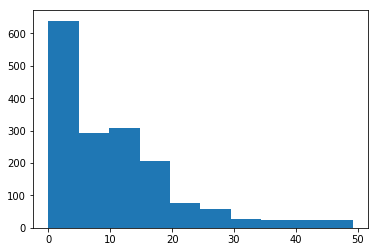

In [4]:
plt.hist(mdp.vD.values())

(array([ 14.,  25.,  94., 103., 111., 154., 155., 229., 256., 536.]),
 array([-629.26947021, -565.9208138 , -502.57215738, -439.22350097,
        -375.87484455, -312.52618814, -249.17753172, -185.8288753 ,
        -122.48021889,  -59.13156247,    4.21709394]),
 <a list of 10 Patch objects>)

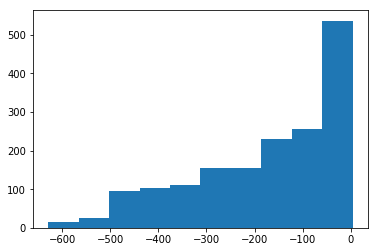

In [5]:
plt.hist(mdp.s_vD.values())

(array([961., 334., 153.,  90.,  38.,  43.,  20.,  12.,  13.,  13.]),
 array([     0.      ,  19114.090625,  38228.18125 ,  57342.271875,
         76456.3625  ,  95570.453125, 114684.54375 , 133798.634375,
        152912.725   , 172026.815625, 191140.90625 ]),
 <a list of 10 Patch objects>)

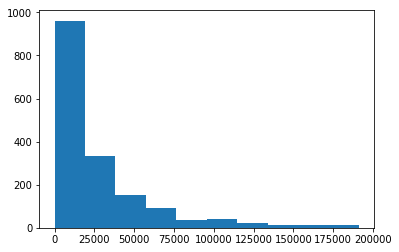

In [6]:
plt.hist(mdp.e_vD.values())

In [3]:
mdp.vi_params

{'gamma': 0.99,
 'slip_prob': 0.1,
 'rmax_reward': 10000,
 'rmax_thres': 10,
 'balanced_explr': True}

In [6]:
# for i, v in enumerate(mdp.explr_tgt_gpu.flatten()):
#     if i in mdp.idx2s:
#         print(mdp.idx2s[i],v)

In [5]:
# s = '[-2, -1, 2, 0]'
# for a in mdp.tD[s]:
#     print(s, a, [(ns, mdp.tD[s][a][ns]) for ns in mdp.tD[s][a]])

In [8]:
# mdp.vD_gpu

array([[ 0.     ],
       [ 0.     ],
       [72.41058],
       ...,
       [ 0.     ],
       [ 0.     ],
       [ 0.     ]], dtype=float32)

In [7]:
s = max(mdp.vD, key = mdp.vD.get)
print(max(mdp.vD.values()))

72.9245834350586


In [7]:
max(mdp.e_vD_gpu.get().flatten())

8946520.0

In [8]:
max(mdp.explr_tgt_gpu.flatten())

2.9338700747903257e+53

In [7]:
mdp.e_vD_gpu[mdp.s2idx['unknown_state']]

array([0.], dtype=float32)

In [13]:
mdp.e_curr_vi_error

1.1828518732429138e+30

In [18]:
mdp.do_explr_backup(mode="GPU",n_backups=1)

In [9]:
print("episode:", eps,
#           "reward:", running_reward,
          #               "Bkp error:", [round(d,6) for d in ray.get(shared_store_1.get_curr_vi_errors.remote())],
          "Bkp error:", [round(d, 6) for d in [mdp.curr_vi_error, mdp.e_curr_vi_error, mdp.s_curr_vi_error]],
          "s8 visited:", len(mdp.tC),
#           "Rmax S8 Count", rmax_count,
          "epsilon", round(eps_tracker.get_eps(frame_count), 2),
          "Eval Reward", eval_reward,
          "policy_fetch_rate", round(mean(policy_fetch_time), 6),
          "bellman_backup_time", round(mean(bellman_backup_time), 6) if bellman_backup_time else 0
          )

episode: 11 Bkp error: [15539.125, 1.1828518732429138e+30, 1237024.754207] s8 visited: 147 epsilon 0.7 Eval Reward 0 policy_fetch_rate 5.8e-05 bellman_backup_time 909.861217


In [15]:
mdp.explr_tgt_gpu

array([[ 0.00000000e+00],
       [-5.41873203e+19],
       [ 1.03677499e+29],
       ...,
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

In [72]:
for i,s in enumerate(mdp.e_rD):
    print(s, [ ((a,r), mdp.s2idx[s], float(mdp.e_rewardMatrix_gpu[a][mdp.s2idx[s]][0].get()) ) for a,r in mdp.e_rD[s].items()])
#     print(s, [ ((a,r), mdp.s2idx[s] (mdp.e_rewardMatrix_gpu[mdp.s2idx[s]][a][0])) for a,r in mdp.e_rD[s].items()])    

[0, 0, 0, 0] [((1, 100.0), 3, 100.0), ((0, 100.0), 3, 100.0)]
[-1, 0, -1, -1] [((0, 80000), 277, 80000.0), ((1, 90000), 277, 90000.0)]
[-1, -1, -1, 0] [((0, 70000), 208, 70000.0), ((1, 90000), 208, 90000.0)]
[-1, -1, -1, 1] [((0, 100.0), 182, 100.0), ((1, 90000), 182, 90000.0)]
[-1, -2, -1, 2] [((1, 10000), 183, 10000.0), ((0, 90000), 183, 90000.0)]
[-1, -1, 0, 1] [((1, 100.0), 75, 100.0), ((0, 100.0), 75, 100.0)]
[-1, -1, 0, 0] [((0, 100.0), 115, 100.0), ((1, 90000), 115, 90000.0)]
[-1, -1, 1, 0] [((1, 30000), 184, 30000.0), ((0, 90000), 184, 90000.0)]
[-1, 0, 1, -1] [((0, 20000), 185, 20000.0), ((1, 90000), 185, 90000.0)]
[-1, 0, 1, 0] [((1, 80000), 304, 80000.0), ((0, 90000), 304, 90000.0)]
[-1, 1, 1, -1] [((0, 70000), 251, 70000.0), ((1, 90000), 251, 90000.0)]
[-1, 0, 0, 0] [((1, 50000), 169, 50000.0), ((0, 90000), 169, 90000.0)]
[-1, 1, 0, -1] [((0, 90000), 170, 90000.0), ((1, 90000), 170, 90000.0)]
[0, 1, -1, -1] [((0, 30000), 43, 30000.0), ((1, 90000), 43, 90000.0)]
[-1, 0, -1, 

KeyError: 3

In [60]:
# mdp.e_rewardMatrix_gpu

array([[[    0.      ,     0.      ,     0.      , ...,     0.      ,
             0.      ,     0.      ],
        [    0.      ,     0.      ,     0.      , ...,     0.      ,
             0.      ,     0.      ],
        [30000.      , 30000.      , 30000.      , ..., 30000.      ,
         30000.      , 30000.      ],
        ...,
        [    0.      ,     0.      ,     0.      , ...,     0.      ,
             0.      ,     0.      ],
        [    0.      ,     0.      ,     0.      , ...,     0.      ,
             0.      ,     0.      ],
        [    0.      ,     0.      ,     0.      , ...,     0.      ,
             0.      ,     0.      ]],

       [[    0.      ,     0.      ,     0.      , ...,     0.      ,
             0.      ,     0.      ],
        [    0.      ,     0.      ,     0.      , ...,     0.      ,
             0.      ,     0.      ],
        [   36.787945,    36.787945,    36.787945, ...,    36.787945,
            36.787945,    36.787945],
        ...,


In [126]:
import math as mth
# Temporary variables
ACTION_COUNT, ROW_COUNT, COL_COUNT = mdp.tranProbMatrix_gpu.shape
MATRIX_SIZE = mth.ceil(mth.sqrt(ROW_COUNT))
BLOCK_SIZE = 16

# get the kernel code from the template
kernel_code = vi_kernel_template % {
    'ROW_COUNT': ROW_COUNT,
    'COL_COUNT': COL_COUNT,
    'ACTION_COUNT': ACTION_COUNT,
    'MATRIX_SIZE': MATRIX_SIZE,
    'GAMMA': mdp.vi_params["gamma"],
    'SLIP_ACTION_PROB': 0
}

# Get grid dynamically by specifying the constant MATRIX_SIZE
if MATRIX_SIZE % BLOCK_SIZE != 0:
    grid = (MATRIX_SIZE // BLOCK_SIZE + 1, MATRIX_SIZE // BLOCK_SIZE + 1, 1)
else:
    grid = (MATRIX_SIZE // BLOCK_SIZE, MATRIX_SIZE // BLOCK_SIZE, 1)

# compile the kernel code and get the compiled module
mod = compiler.SourceModule(kernel_code)
matrixmul = mod.get_function("MatrixMulKernel")

# Empty initialize Target Value and Q vectors
tgt_vD_gpu = gpuarray.empty((ROW_COUNT, 1), np.float32)
tgt_qD_gpu = gpuarray.empty((ROW_COUNT, ACTION_COUNT), np.float32)
tgt_error_gpu = gpuarray.to_gpu(np.zeros((ROW_COUNT, 1)))

try:
    matrixmul(
        # inputs
        self.tranProbMatrix_gpu, mdp.tranidxMatrix_gpu, mdp.e_rewardMatrix_gpu, mdp.e_vD_gpu,
        # output
        tgt_vD_gpu, tgt_qD_gpu, tgt_error_gpu,
        grid=grid,
        # (only one) block of MATRIX_SIZE x MATRIX_SIZE threads
        block=(BLOCK_SIZE, BLOCK_SIZE, 1)
    )
except:
    if (input("d for debugging") == 'd'):
        print(BLOCK_SIZE, BLOCK_SIZE, 1)
        import pdb;
        pdb.set_trace()

mdp.e_vD_gpu.gpudata.free()
mdp.e_qD_gpu.gpudata.free()
mdp.e_vD_gpu = tgt_vD_gpu
mdp.e_qD_gpu = tgt_qD_gpu

mdp.e_gpu_backup_counter += 1
if (mdp.e_gpu_backup_counter+1) % 25 == 0:
    max_error_gpu = gpuarray.max(tgt_error_gpu, stream=None)  # ((value_vector_gpu,new_value_vector_gpu)
    max_error = float(max_error_gpu.get())
    max_error_gpu.gpudata.free()
    mdp.e_curr_vi_error = max_error
tgt_error_gpu.gpudata.free()

d for debugging exit


LogicError: device_allocation::free failed: invalid resource handle